In [1]:
import typing

from river.tree import HoeffdingTreeRegressor, splitter
from river.datasets.synth import Friedman, FriedmanDrift, Hyperplane, ConceptDriftStream, Agrawal
from river.datasets import Bikes, Elec2
from river.evaluate import progressive_val_score
from river.metrics import RMSE

import pandas as pd

In [2]:
class EvaluateModels:
    def __init__(self, models: typing.Dict[str, typing.Any], metric = RMSE(), instances=100000):
        self.models = models
        self.metric = metric
        self.instances = instances

    @staticmethod
    def get_dataset():
        return ConceptDriftStream(
            stream=Hyperplane(n_features=30, n_drift_features=10),
            drift_stream=Hyperplane(n_features=30, n_drift_features=10, mag_change=0.5),
            position=50000,
            width=10000
        )

    def run_experiments(self):
        for model_name, model in self.models.items():
            print("Evaluating models - {}".format(model_name))
            progressive_val_score(
                dataset=self.get_dataset().take(self.instances),
                model=model,
                metric=RMSE(),
                print_every=20000,
                show_time=True,
                show_memory=True,
            )

    def summarize(self):
        summaries = {model_name: model.summary for model_name, model in self.models.items()}
        return pd.DataFrame(index=summaries.keys(), data=summaries.values())

In [3]:
models = {
    'vanilla': HoeffdingTreeRegressor(),
    'qo-splitter-binary': HoeffdingTreeRegressor(splitter=splitter.QOSplitter(allow_multiway_splits=False)),
    'qo-splitter-multi': HoeffdingTreeRegressor(splitter=splitter.QOSplitter(allow_multiway_splits=True)),
    'qo-splitter-multi-clone': HoeffdingTreeRegressor(splitter=splitter.QOSplitter(allow_multiway_splits=True)),
    'qo-splitter-reg-linear-1': HoeffdingTreeRegressor(merit_preprune=False, splitter=splitter.QOFusionRegSplitter(lmb=1, penalty_method='linear')),
    # 'qo-splitter-reg-linear-2': HoeffdingTreeRegressor(splitter=splitter.QOFusionRegSplitter(lmb=0, penalty_method='linear')),
    # 'qo-splitter-reg-linear-3': HoeffdingTreeRegressor(splitter=splitter.QOFusionRegSplitter(lmb=0, penalty_method='linear')),
    # 'qo-splitter-reg-log-1': HoeffdingTreeRegressor(splitter=splitter.QOFusionRegSplitter(lmb=0, penalty_method='log')),
}

In [4]:
data = ConceptDriftStream(
    stream=Hyperplane(n_features=30, n_drift_features=10),
    drift_stream=Hyperplane(n_features=30, n_drift_features=10, mag_change=0.5),
    position=50000,
    width=10000
)

In [5]:
evaluation = EvaluateModels(
    models=models,
)
evaluation.run_experiments()

Evaluating models - vanilla
[20,000] RMSE: 0.407082 – 00:00:05 – 7.58 MiB
[40,000] RMSE: 0.400373 – 00:00:11 – 13.81 MiB
[60,000] RMSE: 0.428262 – 00:00:17 – 18.74 MiB
[80,000] RMSE: 0.447277 – 00:00:25 – 25.24 MiB
[100,000] RMSE: 0.450132 – 00:00:34 – 32.77 MiB
Evaluating models - qo-splitter-binary
[20,000] RMSE: 0.413712 – 00:00:03 – 5.01 MiB
[40,000] RMSE: 0.406473 – 00:00:06 – 9.83 MiB
[60,000] RMSE: 0.429484 – 00:00:09 – 14.05 MiB
[80,000] RMSE: 0.444896 – 00:00:14 – 19.3 MiB
[100,000] RMSE: 0.446903 – 00:00:18 – 25.01 MiB
Evaluating models - qo-splitter-multi
[20,000] RMSE: 0.387817 – 00:00:02 – 2.12 MiB
[40,000] RMSE: 0.376595 – 00:00:06 – 2.43 MiB
[60,000] RMSE: 0.409015 – 00:00:09 – 3.36 MiB
[80,000] RMSE: 0.428875 – 00:00:13 – 7.97 MiB
[100,000] RMSE: 0.43366 – 00:00:16 – 8.58 MiB
Evaluating models - qo-splitter-multi-clone
[20,000] RMSE: 0.409656 – 00:00:02 – 1.71 MiB
[40,000] RMSE: 0.397212 – 00:00:06 – 2.02 MiB
[60,000] RMSE: 0.421048 – 00:00:10 – 6.66 MiB
[80,000] RMSE: 

In [6]:
evaluation.summarize()

,n_nodes,n_branches,n_leaves,n_active_leaves,n_inactive_leaves,height,total_observed_weight
vanilla,487,243,244,244,0,16,100000.0
qo-splitter-binary,513,256,257,257,0,16,100000.0
qo-splitter-multi,111,28,83,83,0,5,100000.0
qo-splitter-multi-clone,189,47,142,142,0,5,100000.0
qo-splitter-reg-linear-1,1,0,1,1,0,1,100000.0



(process:408): Pango-WARNING **: 12:50:45.552: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


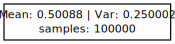

In [7]:
models['qo-splitter-reg-linear-1'].draw()